# Basic imports and obtaining datasets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-09-20 10:27:29.988594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 10:27:29.988624: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../data/views/KuHar/resampled_view_20Hz")

In [4]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [5]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Transforming KuHar to 20Hz

In [6]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [7]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

In [8]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [9]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


# Applying topological autoencoders

In [10]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

dimensions = [1, 50, 100, 150, 170]
topo_models = []
lowdim_test_dataset_fft = []
lowdim_train_dataset_fft = []
lowdim_pyDRMetrics_eval = []
lowdim_classification_eval = []

In [11]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=3, debug=False)

def get_classification_metrics(train_x, train_y, test_x, test_y):
    train_x_pd = pd.DataFrame(train_x)
    train_x_pd['y'] = train_y
    train_dset = PandasMultiModalDataset(
        train_x_pd,
        label_columns="y",
        as_array=True
    )

    test_x_pd = pd.DataFrame(test_x)
    test_x_pd['y'] = test_y
    test_dset = PandasMultiModalDataset(
        test_x_pd,
        label_columns="y",
        as_array=True
    )

    result = multi_run_experiment(train_dset, test_dset)
    return result
# result = multi_run_experiment(combined_train_dset, test_dataset)
# print(yaml.dump(result, sort_keys=True, indent=4))

In [15]:
print(test_dataset_fft.X.shape, test_dataset_fft.X.shape)

(378, 180) (378, 180)


In [14]:
print(test_dataset_after_topoae_transform.shape)

(126, 3)


In [16]:
print(train_dataset_after_topoae_transform.shape)

(1110, 3)


In [18]:
for i in dimensions:
    print('START DIMENSION', i)
    transformer_topoae = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180',
                                                          ae_kwargs={'input_dims':180, 'custom_dim':i},
                                                          input_shape=(-1, 1, 180))
    transformer_topoae.fit(train_dataset_fft.X)
    topo_models.append(transformer_topoae)
    
    # Applying topological autoencoders to train dataset
    train_dataset_after_topoae_transform = transformer_topoae.transform(train_dataset_fft.X)
    train_dataset_after_topoae_transform = np.reshape(train_dataset_after_topoae_transform, (-1,i))
    lowdim_train_dataset_fft.append(train_dataset_after_topoae_transform)
    
    # Applying topological autoencoders to test dataset
    test_dataset_after_topoae_transform = transformer_topoae.transform(test_dataset_fft.X)
    # print(test_dataset_after_topoae_transform.shape)
    test_dataset_after_topoae_transform = np.reshape(test_dataset_after_topoae_transform, (-1,i))
    lowdim_test_dataset_fft.append(test_dataset_after_topoae_transform)
    
    # Evaluating pyDRMetrics to test dataset
    metrics_reporter = DimensionalityReductionQualityReport(sampling_threshold=378)
    metrics_on_test_dataset = metrics_reporter.evaluate([test_dataset_fft.X, test_dataset_after_topoae_transform])
    
    lowdim_pyDRMetrics_eval.append(metrics_on_test_dataset)
    
    # Evaluating classification metrics to test dataset
    lowdim_classification_eval.append(get_classification_metrics(train_dataset_after_topoae_transform,
                                                                 train_dataset_fft.y, 
                                                                 test_dataset_after_topoae_transform,
                                                                 test_dataset_fft.y)) 

START DIMENSION 1
Topologically Regularized DeepAEforKuhar180
Using python to compute signatures
DeepAEforKuhar180, Input: 180 Inner dim: 1
Epoch:1, Loss:174.2752
Epoch:2, Loss:552.2883
Epoch:3, Loss:13.0182
Epoch:4, Loss:2134.4312
Epoch:5, Loss:383.4630
Epoch:6, Loss:2964.5669
Epoch:7, Loss:40.7107
Epoch:8, Loss:161.5325
Epoch:9, Loss:319.8094
Epoch:10, Loss:3414.8091
Epoch:11, Loss:29.0814
Epoch:12, Loss:267.7439
Epoch:13, Loss:165.4735
(378, 1, 1)
START DIMENSION 50
Topologically Regularized DeepAEforKuhar180
Using python to compute signatures
DeepAEforKuhar180, Input: 180 Inner dim: 50
Epoch:1, Loss:163.6949
Epoch:2, Loss:113.0450
Epoch:3, Loss:26.4136
Epoch:4, Loss:228.4241
Epoch:5, Loss:1940.2853
Epoch:6, Loss:13.0033
Epoch:7, Loss:476.7405
Epoch:8, Loss:38.0311
Epoch:9, Loss:70.8428
Epoch:10, Loss:69.1030
Epoch:11, Loss:2746.6838
Epoch:12, Loss:59.8673
Epoch:13, Loss:233.3043
Epoch:14, Loss:67.7478
Epoch:15, Loss:167.4240
(378, 1, 50)
START DIMENSION 100
Topologically Regularize

In [24]:
criteria = 'trustworthiness'
values = [evaluation[criteria] for evaluation in lowdim_pyDRMetrics_eval]
print(values)

[0.733573296986708, 0.8053190004188189, 0.6683780685834368, 0.4371817527204861, 0.5481269792868322]


In [43]:
print(lowdim_pyDRMetrics_eval)

[{'residual variance (pearson)': 0.23025673446358197, 'residual variance (spearman)': 0.34665410986255374, 'trustworthiness': 0.733573296986708, 'continuity': 0.8012387304643012, 'co k nearest neighbor size': 0.16611405835543766, 'local continuity meta criterion': 0.12356086686607595, 'local property': 0.3017443916958182, 'global property': 0.7693086982380619}, {'residual variance (pearson)': 0.43123794264365756, 'residual variance (spearman)': 0.381786280194484, 'trustworthiness': 0.8053190004188189, 'continuity': 0.8930964679603518, 'co k nearest neighbor size': 0.2667440318302387, 'local continuity meta criterion': 0.224190840340877, 'local property': 0.4734547015049188, 'global property': 0.8625360752290179}, {'residual variance (pearson)': 0.8440556421933905, 'residual variance (spearman)': 0.869075990585433, 'trustworthiness': 0.6683780685834368, 'continuity': 0.6839391206271997, 'co k nearest neighbor size': 0.14091511936339524, 'local continuity meta criterion': 0.0983619278740

In [47]:
import matplotlib.pyplot as plt

def plot_criteria(criteria):
    values = [evaluation[criteria] for evaluation in lowdim_pyDRMetrics_eval]
    x = np.array([0,1,2,3, 4])
    my_xticks = ['1','50','100','150', '170']
    plt.xticks(x, my_xticks)
    plt.grid()
    plt.plot(values)
    plt.title(criteria + ' over dimensionalities')
    plt.ylabel(criteria + ' - metric value')
    plt.xlabel('dimensionality')
    plt.ylim((0,1))
    plt.show()

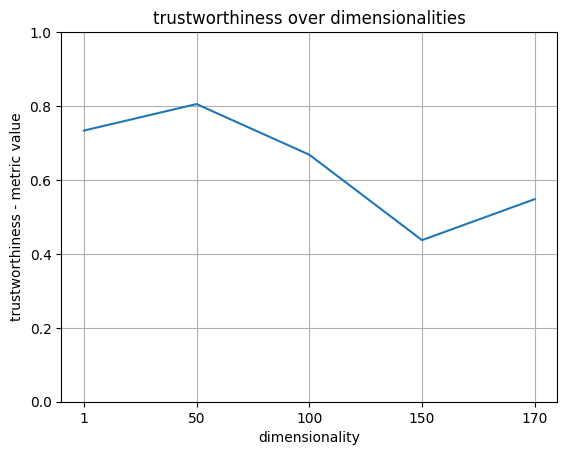

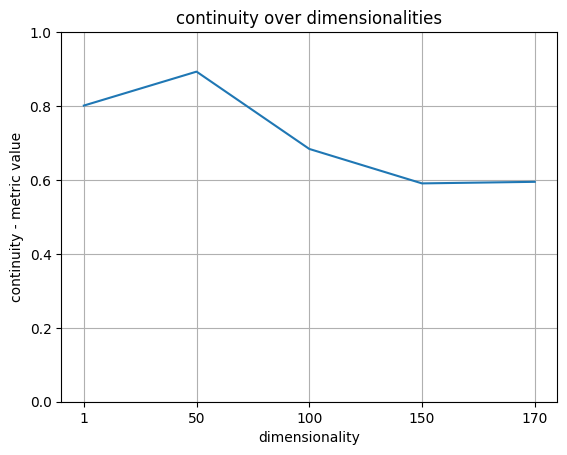

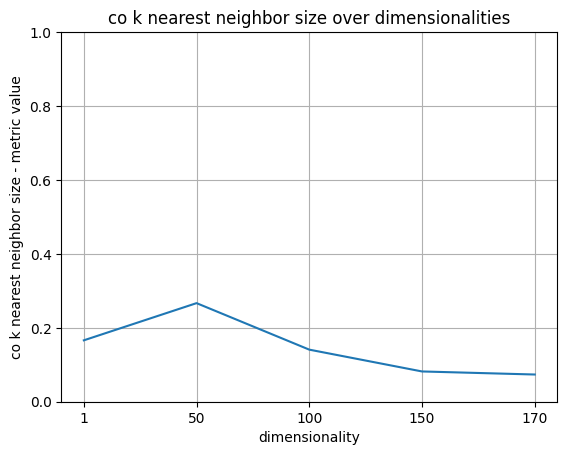

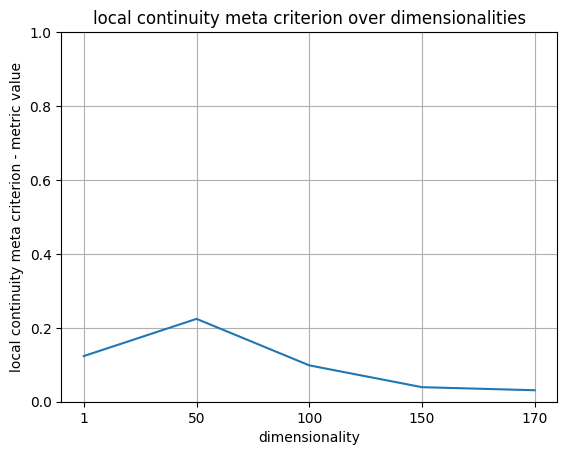

In [48]:
criteria_set = ['trustworthiness', 'continuity', 'co k nearest neighbor size', 'local continuity meta criterion']
for criteria_unit in criteria_set:
    plot_criteria(criteria_unit)

In [20]:
print(lowdim_classification_eval)

[{'runs': [{'run id': 1, 'start': 1663670049.6759033, 'end': 1663670050.0709941, 'time taken': 0.39509081840515137, 'result': [{'accuracy': 0.19047619047619047, 'f1 score (weighted)': 0.19709615725049962, 'f1 score (micro)': 0.19047619047619047, 'f1 score (macro)': 0.18385622370188134}]}, {'run id': 2, 'start': 1663670050.0709968, 'end': 1663670050.4712915, 'time taken': 0.40029478073120117, 'result': [{'accuracy': 0.18783068783068782, 'f1 score (weighted)': 0.19444885901496606, 'f1 score (micro)': 0.18783068783068782, 'f1 score (macro)': 0.18121251664640958}]}, {'run id': 3, 'start': 1663670050.4712934, 'end': 1663670050.8639617, 'time taken': 0.3926682472229004, 'result': [{'accuracy': 0.18783068783068782, 'f1 score (weighted)': 0.19444885901496606, 'f1 score (micro)': 0.18783068783068782, 'f1 score (macro)': 0.18121251664640958}]}]}, {'runs': [{'run id': 1, 'start': 1663670063.4915848, 'end': 1663670065.0287697, 'time taken': 1.5371849536895752, 'result': [{'accuracy': 0.33862433862

In [29]:
criteria = 'accuracy'
f1_values_runs = [evaluation['runs'] for evaluation in lowdim_classification_eval]
for evaluation in lowdim_classification_eval:
    runs = evaluation['runs']
    criteria_set = []
    for run in runs:
        criteria_set.append(run['result'][0][criteria])
        # print('run id', run['run id'])
        # print(run['result'][0][criteria])
    print(np.mean(criteria_set))
# print(f1_values_runs)

0.18871252204585534
0.34215167548500885
0.25661375661375657
0.12169312169312169
0.14109347442680775
